# Serial Test over USB
Connecting to a USB serial port to get data from an Arduino. To install the software run:

`apt-get install python-serial`

In [1]:
%ls /dev/ttyACM*

/dev/ttyACM4


## Setup the serial configuration
Check that the serial device printed by the command above matches the `portPath` below:

In [46]:
import serial
import time
import csv
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
from datetime import datetime
 
portPath = "/dev/ttyACM4"       # Must match value shown on Arduino IDE
baud = 115200                   # Must match Arduino baud rate
timeout = 5                     # Seconds
filename = "data.csv"
max_num_readings = 8
num_signals = 1
 
 
 
def create_serial_obj(portPath, baud_rate, tout):
    """
    Given the port path, baud rate, and timeout value, creates and returns a pyserial object.
    """
    return serial.Serial(portPath, baud_rate, timeout = tout)

In [3]:
def read_serial_data(serial):
    """
    Given a pyserial object (serial). Outputs a list of lines read in from the serial port
    """
    #serial.flushInput()
    serial.reset_input_buffer()
    
    serial_data = []
    readings_left = True
    timeout_reached = False
    
    #Send data to start the transfer
    serial.write(1)
    #Wait for the data to be ready
    time.sleep(2)
    
    while readings_left and not timeout_reached:
        serial_line = serial.readline()
        if serial_line == b'':
            timeout_reached = True
        else:
            serial_data.append(serial_line)
            if len(serial_data) == max_num_readings:
                readings_left = False
        
    return serial_data

In [4]:
print ("Creating serial object...")
serial_obj = create_serial_obj(portPath, baud, timeout)
 
print ("Reading serial data...")
serial_data = read_serial_data(serial_obj)
#print serial_data.len()

Creating serial object...
Reading serial data...


In [39]:
def is_number(string):
    """
    Given a string returns True if the string represents a number.
    Returns False otherwise.
    """
    try:
        float(string)
        return True
    except ValueError:
        return False
        
def clean_serial_data(data):
    """
    Given a list of serial lines (data). Removes all characters.
    Returns the cleaned list of lists of digits.
    Given something like: ['0.5000,33\r\n', '1.0000,283\r\n']
    Returns: [[0.5,33.0], [1.0,283.0]]
    """
    clean_data = []
    
    for line in data:
        line_data = float(line.strip())
        #line_data = re.findall("\d*\.\d*|\d*",line) # Find all digits
        #line_data = [float(element) for element in line_data if is_number(element)] # Convert strings to float
        if line_data >= 0.0:
            clean_data.append(line_data)
        
        clean_data.append(datetime.now())
    return clean_data

In [40]:
print("Cleaning data...")
clean_data =  clean_serial_data(serial_data)
clean_data

Cleaning data...


[19.0, datetime.datetime(2020, 5, 29, 22, 32, 42, 889694)]

In [55]:
clean_data_table = [clean_data]

In [121]:
pd_data_new_row = pd.DataFrame(clean_data_table,columns=["Co2","Date & Time"])
pd_data_new_row

,Co2,Date & Time
0,19,2020-05-29 22:32:42.889694


In [122]:
headers = ["Co2","Date & Time"]
pd_data_new_row.to_csv(filename,names=headers)

In [123]:
df = pd.read_csv(filename,names=headers,skiprows = 1)
df

,Co2,Date & Time
0,19,2020-05-29 22:32:42.889694


In [114]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f')

In [115]:
df.get_value(0, 'Date & Time')

'2020-05-29 22:32:42.889694'

In [116]:
dateparse(df.get_value(0, 'Date & Time'))

datetime.datetime(2020, 5, 29, 22, 32, 42, 889694)

In [127]:
df = pd.read_csv(filename, parse_dates=['Date & Time'], date_parser=dateparse,index_col=0)
df

,Co2,Date & Time
0,19,2020-05-29 22:32:42.889694


In [128]:
type(df.get_value(0, 'Co2'))
df.get_value(0, 'Co2')
type(df.get_value(0, 'Date & Time'))

pandas.tslib.Timestamp

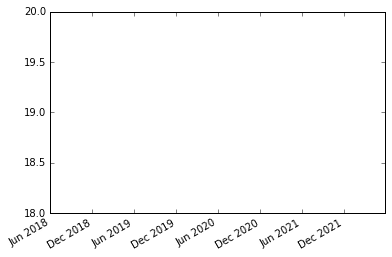

In [129]:
x = df['Date & Time']
y = df['Co2']

# plot
plt.plot(x,y)
# beautify the x-labels
plt.gcf().autofmt_xdate()

plt.show()